<a href="https://colab.research.google.com/github/mujtaba-ssj/PySpark/blob/main/Module5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Exploratory data analysis


## 1.1 Loading files


In [1]:
#Loading files

# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
#library
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.2 Uploading Files

In [4]:
#upload data to directory
from google.colab import files
upload = files.upload()

Saving Telco_Customer.csv to Telco_Customer (1).csv


In [5]:
#1. READ THE DATASET
dataset = spark.read.csv('Telco_Customer.csv', inferSchema=True, header = True)

## 1.3 Exploratory Data Analysis

In [6]:
#displaying the dataset contents
dataset.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [7]:
#number of rows in this dataset
count = dataset.count()
n = dataset.columns
print("The number of columns in this dataset is: %a" %len(n))
print("The number of rows in this dataset is: %a" %count)

The number of columns in this dataset is: 21
The number of rows in this dataset is: 7043


In [8]:
#Schema of dataset
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [9]:
#dropping customer ID as it would be of no use.
dataset = dataset.drop("customerID")

In [10]:
dataset.show()

+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|

In [11]:
#count the country present in the datasets
dataset.groupBy('gender').count().show()

#count the search engine present in the datasets
dataset.groupBy('PhoneService').count().show()

# Count the status
dataset.groupBy('InternetService').count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682|
|         Yes| 6361|
+------------+-----+

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1526|
|            DSL| 2421|
+---------------+-----+



In [12]:
#converting data frame to pandas
db = dataset.toPandas()

In [13]:
#db['TotalCharges'] = db['TotalCharges'].astype(float)
#db[TotalCharges] = db.TotalCharges.astype(float)
#db.TotalCharges

#db["TotalCharges"] = [float(str(i).replace(" ", "")) for i in db["TotalCharges"]]

db.loc[db['TotalCharges'] == ' ', 'TotalCharges'] = 0.0


db['TotalCharges']=db['TotalCharges'].astype(float)


In [14]:
db.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [18]:
db.replace({'No phone service':'No','No internet service':'No'},inplace=True)
db.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
##creating dummies
#db_dummies = pd.get_dummies(db['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','PaymentMethod'])

#pd.get_dummies(db['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','PaymentMethod'])

X=db.drop(['Churn'],axis=1)
y=db['Churn']

In [27]:
columns=[]
for i in X.columns:
    if len(X[i].unique()) < 5:
        columns.append(i)
columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [28]:
X=pd.get_dummies(X,columns=columns,drop_first=True)
X.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0


In [29]:
db.loc[db['TotalCharges'] == ' ', 'TotalCharges'] = 0.0
db['TotalCharges']=db['TotalCharges'].astype(float)

X.loc[X['TotalCharges'] == ' ', 'TotalCharges'] = 0.0
X['TotalCharges']=X['TotalCharges'].astype(float)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7043 non-null   int32  
 1   MonthlyCharges                         7043 non-null   float64
 2   TotalCharges                           7043 non-null   float64
 3   gender_Male                            7043 non-null   uint8  
 4   SeniorCitizen_1                        7043 non-null   uint8  
 5   Partner_Yes                            7043 non-null   uint8  
 6   Dependents_Yes                         7043 non-null   uint8  
 7   PhoneService_Yes                       7043 non-null   uint8  
 8   MultipleLines_Yes                      7043 non-null   uint8  
 9   InternetService_Fiber optic            7043 non-null   uint8  
 10  InternetService_No                     7043 non-null   uint8  
 11  Onli

In [30]:
from sklearn.preprocessing import StandardScaler
columns=['tenure','MonthlyCharges','TotalCharges']
X_scaled=StandardScaler().fit_transform(X[columns])
X['tenure']=X_scaled[:,0]
X['MonthlyCharges']=X_scaled[:,1]
X['TotalCharges']=X_scaled[:,1]
X.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.277445,-1.160323,-1.160323,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.066327,-0.259629,-0.259629,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,-1.236724,-0.362660,-0.362660,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0.514251,-0.746535,-0.746535,1,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,-1.236724,0.197365,0.197365,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0


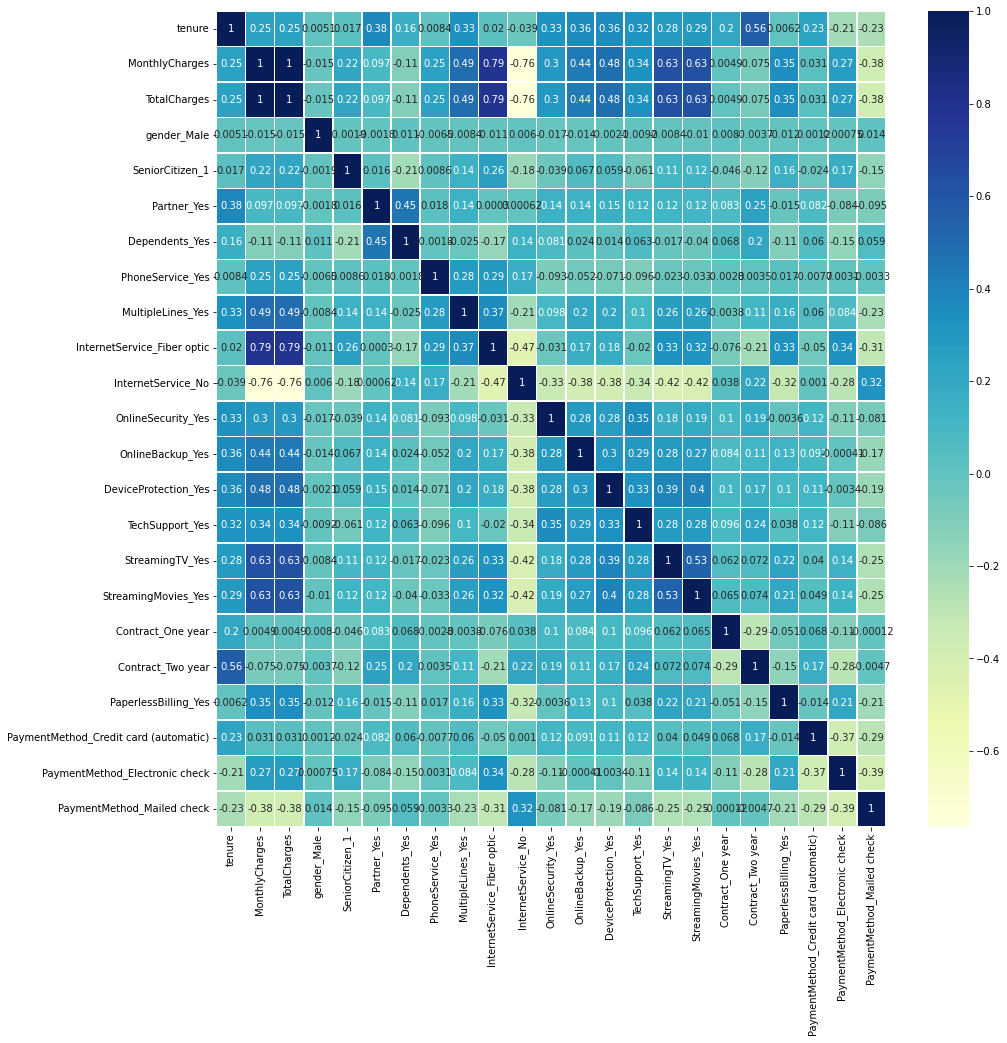

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(),annot=True,cmap='YlGnBu',linewidths=.5)

In [32]:
db.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [33]:
#target variable count
dataset.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [34]:
db.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

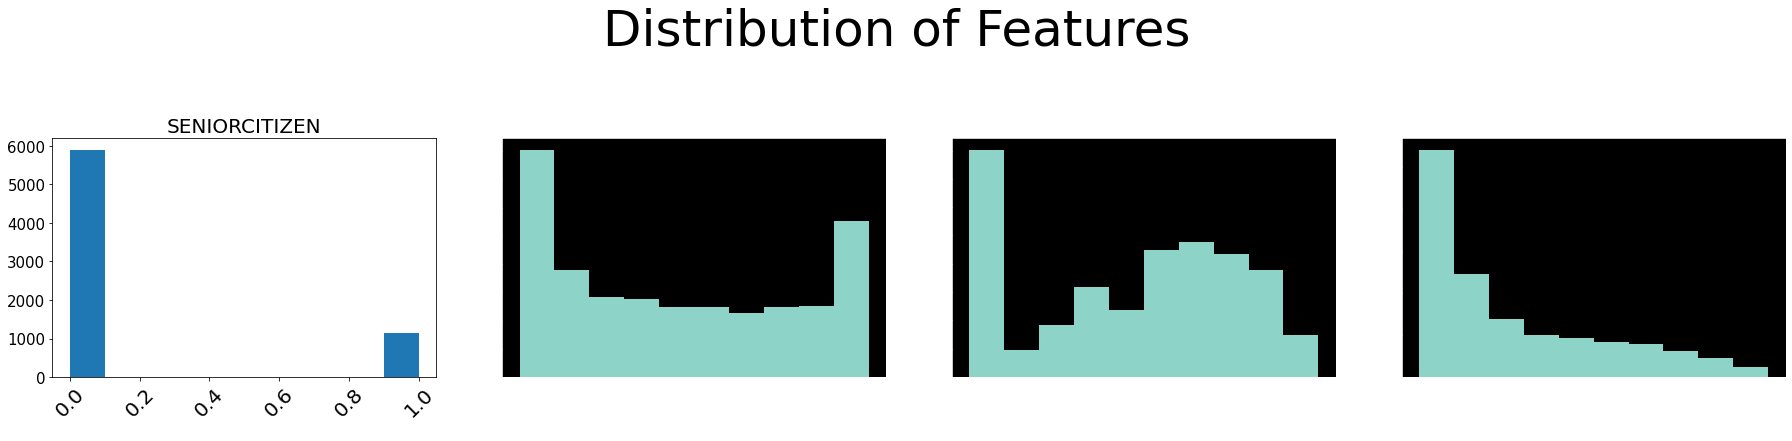

In [35]:
#checking for distribtuion of features
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(db.describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(db[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [ ]:
db.info()

In [36]:
#converting total charges to double

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
dataset = dataset.withColumn("TotalCharges",dataset.TotalCharges.cast('double'))
cols = dataset.columns
dataset.printSchema()
#dataset.show()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [37]:
dataset.filter(col("TotalCharges").isNull()).show()

+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|       Yes|     0|          No|No phone service|            DSL|                Ye

In [38]:
#dataset.filter(col("TotalCharges").isNull()).show()
#cols = dataset.columns
dataset.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [39]:
from pyspark.sql.functions import mean
dataset_mean = dataset.fillna(value=0,subset=['TotalCharges']).select(mean(col('TotalCharges')).alias('avg')).collect()
avg = dataset_mean[0]['avg']

#dataset = dataset.withColumn('TotalCharges', F.udf(lambda x: avg if x is None else x)(F.col('TotalCharges')))
dataset = dataset.fillna(value=avg, subset=['TotalCharges'])
dataset.show()

+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|

In [40]:
#no null in dataset.
dataset.filter(col("TotalCharges").isNull()).show()
cols = dataset.columns

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+---

# 2. Feature Selection & Logistic Regression

In [41]:
#Regression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['gender','SeniorCitizen','Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Churn', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['tenure', 'MonthlyCharges', 'TotalCharges']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [68]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset)
selectedCols = ['label', 'features'] + cols
dataset = dataset.select(selectedCols)
dataset.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = false)
 |-- Churn: string (nullable = true)



## 2.1 Splitting into train and test set

In [44]:
train, test = dataset.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4978
Test Dataset Count: 2065


## 2.2 Creating logistic model

In [51]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

## 2.3 Model Coefficients

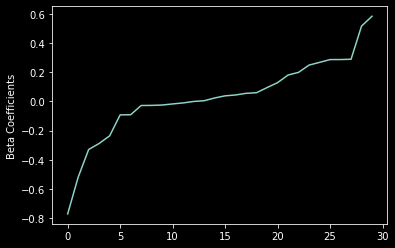

[-0.017097241590190593,-0.2883437632157609,0.0599792822893911,-0.010154905575850168,-0.520203308656747,-0.23613368068998805,0.055757923017949164,0.5173537221344754,-0.3300725765599269,0.28745325034004315,-0.09132751963526736,0.18132548658188538,0.038494631090618354,0.1290178011509141,0.09531233729293942,0.2896687307280117,-0.09223090954743536,-0.02459295014308865,0.24965204067095437,0.023742670312757824,0.1997319758411983,0.5849869046480347,-0.7721581244962104,0.2682303249744738,0.2877315539156376,0.04450418915438155,-0.02789761286499099,-0.027060836615744332,0.004930498491205233,-7.149400134078705e-05]


In [67]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
print(lrModel.coefficients)

## 2.4 AUC-ROC Curve

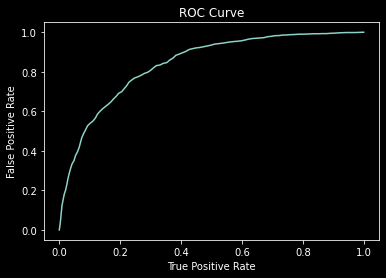

Training set areaUnderROC: 0.8384875592377685


In [47]:
#auc and roc
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

##2.5 Predictions

In [48]:
#prediction on dataset

predictions = lrModel.transform(test)
predictions.select('gender','TotalCharges','SeniorCitizen', 'Churn', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------+------------+-------------+-----+-----+--------------------+----------+--------------------+
|gender|TotalCharges|SeniorCitizen|Churn|label|       rawPrediction|prediction|         probability|
+------+------------+-------------+-----+-----+--------------------+----------+--------------------+
|  Male|      157.75|            0|   No|  0.0|[-0.3766130053905...|       1.0|[0.40694405801491...|
|  Male|      488.65|            0|   No|  0.0|[0.08907705232743...|       0.0|[0.52225454972346...|
|  Male|     2958.95|            0|   No|  0.0|[1.24052117530448...|       0.0|[0.77565471934547...|
|  Male|      2001.0|            0|   No|  0.0|[0.13236165049902...|       0.0|[0.53304218619639...|
|  Male|      237.65|            0|   No|  0.0|[-0.6659996293194...|       1.0|[0.33939316861433...|
|  Male|     1725.95|            0|   No|  0.0|[0.90557517411903...|       0.0|[0.71209385380706...|
|  Male|      818.45|            0|   No|  0.0|[-0.0795139518320...|       1.0|[0.480131978

In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8589511365670291


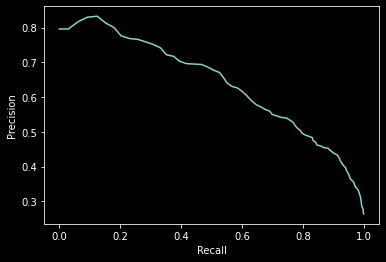

In [50]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## 2.6 Metrics

In [64]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8057452792286058
FPR: 0.36741113168751327
TPR: 0.8057452792286058
F-measure: 0.7986400816275957
Precision: 0.7965592346520947
Recall: 0.8057452792286058
